# Display images and boxes so that we know which dimensions refers to which!!!!

In [1]:
import subprocess
from pathlib import Path

scan_id = 'summit-2226-bxt_Y0_BASELINE_A'
study_id = scan_id.split('_')[0]

if not Path(f'fixtures/scans/{study_id}').exists():
    Path(f'fixtures/scans/{study_id}').mkdir(parents=True, exist_ok=True)
    command = f'scp -P 2222 "jmccabe@localhost:/cluster/project2/SummitLung50/{study_id}/{scan_id}*" fixtures/scans/{study_id}'
    subprocess.run(command, shell=True)

if not Path(f'fixtures/nifti/{study_id}/{scan_id}.nii.gz').exists():
    Path(f'fixtures/nifti/{study_id}').mkdir(parents=True, exist_ok=True)
    command = f'scp -P 2222 jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/detection/summit/{study_id}/{scan_id}.nii.gz fixtures/nifti/{study_id}/{scan_id}.nii.gz'
    subprocess.run(command, shell=True)



(-162.9, -175.5, -284.875) (0.685547, 0.685547, 0.625) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


,0
form_instance_id,Bwnvnu52_Pew4IltHDf54RmNOXnpI6TGv6vOmLeH3pE
form_instance_status,COMPLETED
participant_id,summit-2226-bxt
form_instance_index,0.0
nodule_brock_score,2.03
nodule_category,BASELINE
nodule_diameter_mm,7.2
nodule_lesion_id,1.0
nodule_lung_rads,2
nodule_mass,29.9


[[ -74.77  -27.73 -145.13]]
[[128 215 223]]


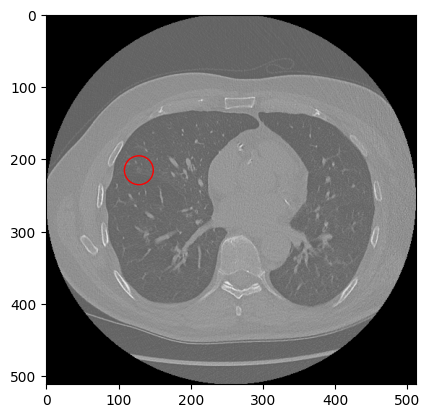

In [2]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

scan = sitk.ReadImage(f'fixtures/scans/{study_id}/{scan_id}.mhd')
img = sitk.GetArrayFromImage(scan)
origin = scan.GetOrigin()
spacing = scan.GetSpacing()
orientation = scan.GetDirection()

print(origin, spacing, orientation)


md = pd.concat([
    pd.read_csv('../../metadata/summit/optimisation_actionable/validation_metadata.csv'),
    pd.read_csv('../../metadata/summit/optimisation_actionable/training_metadata.csv'),
    pd.read_csv('../../metadata/summit/optimisation_actionable/test_metadata.csv'),
    pd.read_csv('../../metadata/summit/optimisation_actionable/holdout_metadata.csv'),
]).query('scan_id == @scan_id')


display(md.T)

real_world_coords = md[['nodule_x_coordinate', 'nodule_y_coordinate', 'nodule_z_coordinate']].values
vox_coords = ((real_world_coords  - np.array(origin)) / np.array(spacing))
print(real_world_coords)
print(vox_coords.astype(int))

x, y, z = vox_coords[0].astype(int)
fig, ax = plt.subplots(1)
ax.imshow(img[z], cmap='gray')
circle = plt.Circle((x, y), radius=20, color='r', fill=False)
ax.add_patch(circle)
plt.show()


In [3]:
import argparse
import json
import logging
import sys
import time
from copy import deepcopy

import monai
import numpy as np
import torch
from generate_transforms import generate_detection_train_transform
from monai.apps.detection.networks.retinanet_detector import RetinaNetDetector
from monai.apps.detection.networks.retinanet_network import (
    RetinaNet, resnet_fpn_feature_extractor)
from monai.apps.detection.transforms.dictionary import ClipBoxToImaged
from monai.apps.detection.utils.anchor_utils import \
    AnchorGeneratorWithAnchorShape
from monai.data import DataLoader, Dataset, load_decathlon_datalist
from monai.data.utils import no_collation
from monai.networks.nets import resnet
from monai.transforms import (Compose, DeleteItemsd, Invertd,
                              ScaleIntensityRanged)


patch_size = [512,512,208]

# 1. define transform
intensity_transform = ScaleIntensityRanged(
    keys=["image"],
    a_min=-1024,
    a_max=300.0,
    b_min=0.0,
    b_max=1.0,
    clip=True,
)

train_transforms = generate_detection_train_transform(
    "image",
    "box",
    "label",
    "cccwhd",
    intensity_transform,
    [96, 96, 48],
    1,
    affine_lps_to_ras=True,
    amp=True,
)

dataset = {'test' : []}
for scan_id, group in md.groupby('scan_id'):
    dataset['test'].append({
        'image': f'{study_id}/{scan_id}.nii.gz',
        'label': [1] * len(group),
        'box': group[[
            'nodule_x_coordinate',
            'nodule_y_coordinate',
            'nodule_z_coordinate',
            'nodule_diameter_mm',
            'nodule_diameter_mm',
            'nodule_diameter_mm'
        ]].values.tolist()
    })

print(dataset, flush=True)

with open('fixtures/detection_test.json', 'w') as f:
    json.dump(dataset, f)

# 2. create a inference data loader
train_data = load_decathlon_datalist(
    "./fixtures/detection_test.json",
    is_segmentation=True,
    data_list_key="test",
    base_dir="./fixtures/nifti",
)

train_ds = Dataset(
    data=train_data,
    transform=train_transforms,
)

print(train_ds.__len__(), flush=True)

train_loader = DataLoader(
    train_ds,
    batch_size=1,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=no_collation,
)


{'test': [{'image': 'summit-2226-bxt/summit-2226-bxt_Y0_BASELINE_A.nii.gz', 'label': [1], 'box': [[-74.77, -27.73, -145.13, 7.2, 7.2, 7.2]]}]}
1


image shape: torch.Size([1, 499, 499, 246]), image dtype: torch.float16
box: tensor([[367.7646, 282.9433, 108.9160, 378.0046, 293.1833, 114.6760]])
label: tensor([1])
[181.7646484375, 102.94332885742188, 108.91600036621094, 192.004638671875, 113.18331909179688, 114.67601013183594]


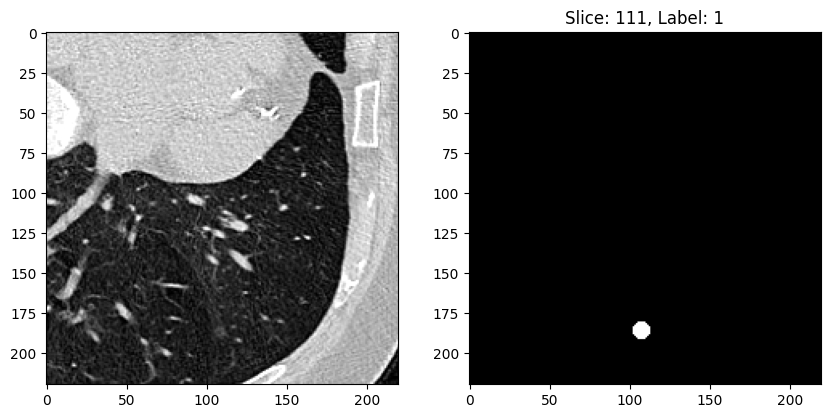

In [5]:

first_batch = next(iter(train_loader))

import matplotlib.pyplot as plt
import torch



# Extract the data
image = first_batch[0][0]['image'][0]  # Remove channel dimension
mask = first_batch[0][0]['box_mask'][0]  # Remove channel dimension
box = first_batch[0][0]['box'][0].tolist()  # Extract box coordinates as a list
label = first_batch[0][0]['label'].item()  # Extract label as scalar

print(box)

# Select a slice (e.g., z=75)
z_slice = int((box[2] + box[5]) // 2)  # z_min
image_slice = image[:, :, z_slice].numpy()  # Convert to NumPy array
mask_slice = mask[:, :, z_slice].numpy()  # Convert to NumPy array

# Extract bounding box coordinates for the slice
x_min, y_min, z_min, x_max, y_max, z_max = box
if z_min <= z_slice <= z_max:  # Only overlay if the slice intersects the box
    x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

    # Plot the slice
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    ax[0].imshow(image_slice, cmap='gray')
    ax[1].imshow(mask_slice, cmap='gray')
    # ax[0].add_patch(plt.Rectangle(
    #     (y_min, x_min),  # (x, y) of the top-left corner
    #     y_max - y_min,   # Width
    #     x_max - x_min,   # Height
    #     edgecolor='r', facecolor='none', linewidth=2
    # ))
    plt.title(f"Slice: {z_slice}, Label: {label}")
    plt.show()
else:
    print(f"No bounding box on slice {z_slice}.")
